In [1]:
import read_data
import pandas as pd
import numpy as np
from IPython import embed
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn
import logging
import six
import scipy.stats
from sklearn.preprocessing import Imputer


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
df=pd.read_csv('dyl_ecoli_df.csv',usecols=['index', 'Week', 'Yearday', 'Monthday', 'Weekday',
       'Month', 'Timestamp', 'Beach', 'Ecoli', 'Year'],index_col=[0],parse_dates=[6])
forecast_df=pd.read_csv('dyl_forecast_df.csv',usecols=['beach', 'time', 'precipIntensity', 'precipProbability',
       'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'windSpeed', 'visibility', 'cloudCover', 'pressure', 'Breezy', 'Dry',
       'Foggy', 'Humid', 'MostlyCloudy', 'PartlyCloudy', 'Overcast', 'Clear',
       'Drizzle', 'DangerouslyWindy', 'Windy', 'HeavyRain', 'LightRain',
       'Rain', 'windSin', 'windCos'],parse_dates=[1])
forecast_df['windCos']=forecast_df['windCos']*forecast_df['windSpeed']
forecast_df['windSin']=forecast_df['windSin']*forecast_df['windSpeed']
forecast_df=forecast_df.drop(['windSpeed'],axis=1)
df=df[df.Timestamp.dt.hour==0]

In [3]:
dfs=[]
for y in range(2006,2015):
    dfs.append(pd.DataFrame(index=pd.DatetimeIndex(start=df.Timestamp[df.Year==y].min()-pd.Timedelta(days=10),freq='H',end=df.Timestamp[df.Year==y].max())));
timeindexed_df=pd.concat(dfs)

for beach in df.Beach.unique():
    b=beach.replace(' ','').strip()
    timeindexed_df['ecoli_'+b]=np.nan
    timeindexed_df.loc[df.Timestamp[df.Beach==beach],'ecoli_'+b]=df.Ecoli[df.Beach==beach].values

for beach in df.Beach.unique():
    b=beach.replace(' ','').strip()
    sub_df=forecast_df[forecast_df.beach==beach]
    for c in (set(forecast_df.columns)-set(['time','beach'])):
        timeindexed_df[c+'_'+b]=np.nan
        timeindexed_df.loc[sub_df.time,c+'_'+b]=sub_df[c].values


In [4]:
predictor_pcas=pd.DataFrame(index=timeindexed_df.index)
for c in (set(forecast_df.columns)-set(['time','beach'])):
    forecast_pivot=forecast_df.pivot(index='time',columns='beach',values=c)
    forecast_pivot.drop('39th',axis=1,inplace=True)
    forecast_pivot=forecast_pivot[forecast_pivot.notnull().all(axis=1)]
    forecast_pivot=forecast_pivot.loc[forecast_pivot.notnull().all(axis=1),:]
    pca=PCA(n_components=6)
    predictor_pcas=predictor_pcas.merge(pd.DataFrame(pca.fit_transform(forecast_pivot),index=forecast_pivot.index,columns=[c+'0',c+'1',c+'2',c+'3',c+'4',c+'5']),left_index=True,right_index=True,how='outer')

c='Ecoli'
ecoli_pivot=df.pivot(index='Timestamp',columns='Beach',values=c)
ecoli_pivot.drop('39th',axis=1,inplace=True)
ecoli_pivot=ecoli_pivot[ecoli_pivot.notnull().all(axis=1)]
ecoli_pivot=ecoli_pivot.loc[ecoli_pivot.notnull().all(axis=1),:]
pca=PCA(n_components=6)
predictor_pcas=predictor_pcas.merge(pd.DataFrame(pca.fit_transform(ecoli_pivot),index=ecoli_pivot.index,columns=[c+'0',c+'1',c+'2',c+'3',c+'4',c+'5']),left_index=True,right_index=True,how='outer')


In [5]:
pca_hit_means={}
pca_miss_means={}
pca_hit_stds={}
pca_miss_stds={}
pca_hit_counts={}
pca_miss_counts={}
# pca_hitmiss_kw={}
pca_hitmiss_mwu={}
pca_hitmiss_ranksum={}
all_columns=predictor_pcas.columns
empty_dt_df=pd.DataFrame(columns=all_columns,
                         index=pd.timedelta_range(start='8H', end='-24H',freq='-1H').append(pd.timedelta_range(start='-2 days', end='-10 days',freq='-1D')))
for beach in df.Beach.unique():
    b=beach.replace(' ','').strip()
    print(b)
    sub_df=df[df.Beach==beach]
    pca_hit_means[b]=empty_dt_df.copy()
    pca_miss_means[b]=empty_dt_df.copy()
    pca_hit_stds[b]=empty_dt_df.copy()
    pca_miss_stds[b]=empty_dt_df.copy()
    pca_hit_counts[b]=empty_dt_df.copy()
    pca_miss_counts[b]=empty_dt_df.copy()
#     pca_hitmiss_kw[b]=empty_dt_df.copy()
    pca_hitmiss_mwu[b]=empty_dt_df.copy()
    pca_hitmiss_ranksum[b]=empty_dt_df.copy()

    hit_times=sub_df.Timestamp[sub_df.Ecoli>=235]
    miss_times=sub_df.Timestamp[sub_df.Ecoli<235]
    for dt in pd.timedelta_range(start='8H', end='-24H',freq='-1H').append(pd.timedelta_range(start='-2 days', end='-10 days',freq='-1D')):
        shift_hit=hit_times+dt
        shift_miss=miss_times+dt
        pca_hit_means[b].loc[dt,:]=predictor_pcas.loc[shift_hit].mean();
        pca_miss_means[b].loc[dt,:]=predictor_pcas.loc[shift_miss].mean();
        pca_hit_stds[b].loc[dt,:]=predictor_pcas.loc[shift_hit].std();
        pca_miss_stds[b].loc[dt,:]=predictor_pcas.loc[shift_miss].std();
        pca_hit_counts[b].loc[dt,:]=predictor_pcas.loc[shift_hit].notnull().sum();
        pca_miss_counts[b].loc[dt,:]=predictor_pcas.loc[shift_miss].notnull().sum();

        for f in all_columns:
            if ~np.isnan(predictor_pcas.loc[shift_hit,f].sum()):
                try:
                    pca_hitmiss_mwu[b].loc[dt,f]=scipy.stats.mstats.mannwhitneyu(predictor_pcas.loc[shift_hit,f],predictor_pcas.loc[shift_miss,f]).pvalue+scipy.stats.mstats.mannwhitneyu(predictor_pcas.loc[shift_miss,f],predictor_pcas.loc[shift_hit,f]).pvalue;
                    pca_hitmiss_ranksum[b].loc[dt,f]=scipy.stats.ranksums(predictor_pcas.loc[shift_miss,f],predictor_pcas.loc[shift_hit,f]).pvalue;
#                     pca_hitmiss_kw[b].loc[dt,f]=scipy.stats.mstats.kruskalwallis(predictor_pcas.loc[shift_hit,f],predictor_pcas.loc[shift_miss,f]).pvalue;
                except:
                    continue

Calumet
Rainbow
SouthShore
63rd
57th
31st
12th
Ohio
OakStreet
NorthAvenue
Montrose
Foster
Osterman
Albion
Leone
Jarvis
Howard
Rogers
Juneway
39th


In [6]:
predictors_df=df.copy();
for c in (set(forecast_df.columns)-set(['time','beach'])):
    predictors_df[c+'0']=0
    predictors_df[c+'1']=0
    predictors_df[c+'A']=0
predictors_df['Ecoli0']=0
predictors_df['Ecoli1']=0
predictors_df['EcoliA']=0
predictors_df.reset_index(inplace=True)

In [7]:
for beach in predictors_df.Beach.unique():
    beach_hits=predictors_df.Beach==beach
    beach_index=predictors_df.index[beach_hits]
    beach_times=predictors_df.loc[beach_hits,'Timestamp']
    b=beach.replace(' ','').strip()
    print(b)
    for dt in pd.timedelta_range(start='8H', end='-24H',freq='-1H').append(pd.timedelta_range(start='-2 days', end='-10 days',freq='-1D')):
        shift_times=beach_times+dt
        for c in (set(forecast_df.columns)-set(['time','beach'])):
            score=(predictor_pcas.loc[beach_times+dt,c+'0']-pca_miss_means[b].loc[dt,c+'0'])*(pca_hit_means[b].loc[dt,c+'0']-pca_miss_means[b].loc[dt,c+'0'])*(1-pca_hitmiss_ranksum[b].loc[dt,c+'0'])**100;
            predictors_df.loc[beach_index[score.notnull()],c+'0']+=score[score.notnull()].values;
            
            score=(predictor_pcas.loc[beach_times+dt,c+'1']-pca_miss_means[b].loc[dt,c+'1'])*(pca_hit_means[b].loc[dt,c+'1']-pca_miss_means[b].loc[dt,c+'1'])*(1-pca_hitmiss_ranksum[b].loc[dt,c+'1'])**100;
            predictors_df.loc[beach_index[score.notnull()],c+'1']+=score[score.notnull()].values;
            
            score=((predictor_pcas.loc[beach_times+dt,[c+'2',c+'3',c+'4',c+'5']]-pca_miss_means[b].loc[dt,[c+'2',c+'3',c+'4',c+'5']])*(pca_hit_means[b].loc[dt,[c+'2',c+'3',c+'4',c+'5']]-pca_miss_means[b].loc[dt,[c+'2',c+'3',c+'4',c+'5']])*(1-pca_hitmiss_ranksum[b].loc[dt,[c+'2',c+'3',c+'4',c+'5']])**100).sum(axis=1);
            predictors_df.loc[beach_index[score.notnull()],c+'A']+=score[score.notnull()].values;
        c='Ecoli'
        if dt.days<0:
            score=(predictor_pcas.loc[beach_times+dt,c+'0']-pca_miss_means[b].loc[dt,c+'0'])*(pca_hit_means[b].loc[dt,c+'0']-pca_miss_means[b].loc[dt,c+'0'])*(1-pca_hitmiss_ranksum[b].loc[dt,c+'0'])**100;
            predictors_df.loc[beach_index[score.notnull()],c+'0']+=score[score.notnull()].values;
            
            score=(predictor_pcas.loc[beach_times+dt,c+'1']-pca_miss_means[b].loc[dt,c+'1'])*(pca_hit_means[b].loc[dt,c+'1']-pca_miss_means[b].loc[dt,c+'1'])*(1-pca_hitmiss_ranksum[b].loc[dt,c+'1'])**100;
            predictors_df.loc[beach_index[score.notnull()],c+'1']+=score[score.notnull()].values;
            
            score=((predictor_pcas.loc[beach_times+dt,[c+'2',c+'3',c+'4',c+'5']]-pca_miss_means[b].loc[dt,[c+'2',c+'3',c+'4',c+'5']])*(pca_hit_means[b].loc[dt,[c+'2',c+'3',c+'4',c+'5']]-pca_miss_means[b].loc[dt,[c+'2',c+'3',c+'4',c+'5']])*(1-pca_hitmiss_ranksum[b].loc[dt,[c+'2',c+'3',c+'4',c+'5']])**100).sum(axis=1);
            predictors_df.loc[beach_index[score.notnull()],c+'A']+=score[score.notnull()].values;

        



Calumet
Rainbow
SouthShore
63rd
57th
31st
12th
Ohio
OakStreet
NorthAvenue
Montrose
Foster
Osterman
Albion
Leone
Jarvis
Howard
Rogers
Juneway
39th


2006
2007
2008
2009
2010
2011
2012
2013
2014


(0.0, 1.0, 0.0, 1.0)

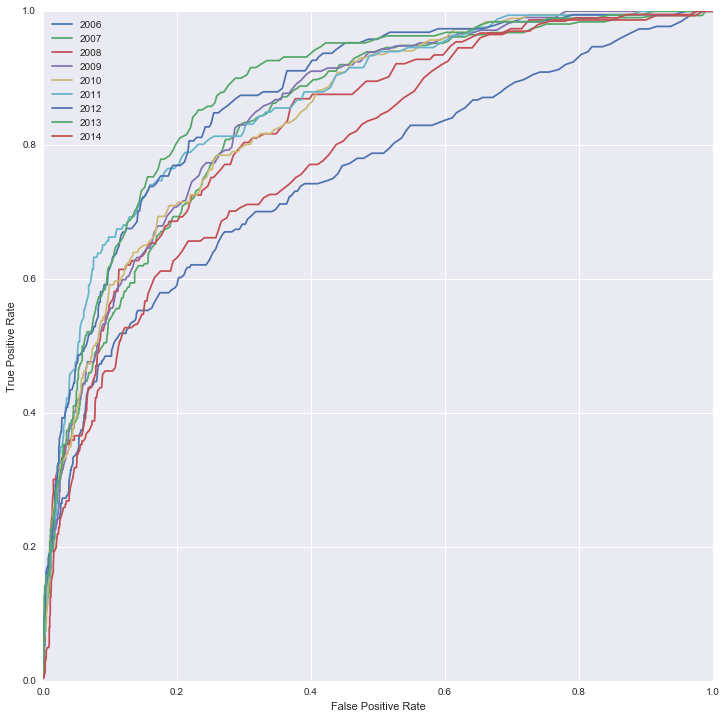

In [8]:
from sklearn.preprocessing import Imputer
import sklearn.ensemble as ens
import sklearn.metrics
%matplotlib inline

Fresh_run=predictors_df.copy()
# usingParams=['Year','Ecoli_geomean','precipIntensity','precipProbability','temperature','apparentTemperature','dewPoint','cloudCover','pressure','windSin','windCos','precipIntensity_pca','precipProbability_pca','temperature_pca','apparentTemperature_pca','dewPoint_pca','cloudCover_pca','pressure_pca','windCos_pca','dtemperature_pca','dapparentTemperature_pca','dvisibility_pca','dwindCos_pca']
# Fresh_run=ecoli_df.loc[:,usingParams].copy()
Fresh_run=Fresh_run.drop(['index','Timestamp','Beach'],1)

years=Fresh_run.Year.unique()
columns=Fresh_run.columns.drop(['Ecoli'])

speration=(predictors_df[predictors_df.Ecoli>=235].mean()-predictors_df[predictors_df.Ecoli<235].mean())/predictors_df[predictors_df.Ecoli<235].std()
predictor_columns=speration[speration>0.15].index
predictor_columns=predictor_columns.drop('Ecoli')
# Fresh_run.loc[Fresh_run[np.isinf(Fresh_run.precipIntensity)].index,'precipIntensity']=100;
# Fresh_run.loc[Fresh_run[np.isinf(Fresh_run.precipProbability)].index,'precipProbability']=100;

#  imp = Imputer(missing_values='NaN', strategy='mean', axis=1)
cleaned_data = Fresh_run[columns]

E_levels=Fresh_run.Ecoli.as_matrix()

plt.figure(figsize=[12,12])
RF=list()
count=0;
predictions=list()
E_test=list()
legend=list()
for y in years:
    print(y)
    train_ind=(cleaned_data.Year != y).as_matrix()
    test_ind=(cleaned_data.Year == y).as_matrix()

    RF.append(ens.RandomForestClassifier(n_estimators=500,criterion='entropy',class_weight={True:.8,False:.2}))
    RF[count]=RF[count].fit(cleaned_data.loc[train_ind,predictor_columns],E_levels[train_ind]>=235)
    predictions.append(RF[count].predict_proba(cleaned_data.loc[test_ind,predictor_columns]))
    E_test.append(E_levels[test_ind])
    fpr, tpr, _ =sklearn.metrics.roc_curve(E_test[count]>=235,predictions[count][:,1])
    plt.plot(fpr,tpr)
    plt.hold(True)
    count+=1
    legend.append(y)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(legend,loc=0)
plt.axis('equal')


In [9]:
coverage=list()
for count in range(0,9):
    temp=predictions[count][:,1].copy()
    temp=E_test[count][temp.argsort()]>235
    temp=temp[::-1]
    temp2=np.cumsum(temp)/np.arange(1,temp.size+1)
    temp3=np.argwhere(temp2>0.45).max()
    coverage.append(temp2[temp3]*(temp3+1)/temp.sum())


In [10]:
coverage

[0.55303030303030298,
 0.81469648562300323,
 0.43790849673202614,
 0.59905660377358494,
 0.59677419354838712,
 0.66265060240963858,
 0.67015706806282727,
 0.65263157894736845,
 0.38308457711442784]

In [11]:
predictor_columns

Index(['dewPoint0', 'dewPoint1', 'dewPointA', 'temperature0', 'temperature1',
       'temperatureA', 'windCos0', 'windCos1', 'windCosA',
       'apparentTemperature0', 'apparentTemperature1', 'apparentTemperatureA',
       'humidity0', 'humidity1', 'humidityA', 'precipProbability0',
       'PartlyCloudy1', 'PartlyCloudyA', 'pressure0', 'pressure1', 'pressureA',
       'visibility0', 'visibilityA', 'cloudCover0', 'cloudCover1',
       'cloudCoverA', 'Overcast0', 'MostlyCloudy0', 'MostlyCloudy1',
       'MostlyCloudyA', 'Clear0', 'Clear1', 'ClearA', 'precipIntensity0',
       'precipIntensity1', 'windSin0', 'windSin1', 'windSinA', 'LightRain0',
       'Ecoli0', 'Ecoli1', 'EcoliA'],
      dtype='object')

In [12]:
speration[predictor_columns]

dewPoint0               0.432509
dewPoint1               0.196493
dewPointA               0.365651
temperature0            0.460610
temperature1            0.295226
temperatureA            0.387348
windCos0                0.478939
windCos1                0.365710
windCosA                0.276316
apparentTemperature0    0.461065
apparentTemperature1    0.305451
apparentTemperatureA    0.418885
humidity0               0.177727
humidity1               0.261674
humidityA               0.295696
precipProbability0      0.378427
PartlyCloudy1           0.177688
PartlyCloudyA           0.250869
pressure0               0.278737
pressure1               0.383354
pressureA               0.435342
visibility0             0.199315
visibilityA             0.165053
cloudCover0             0.428273
cloudCover1             0.172978
cloudCoverA             0.299041
Overcast0               0.171922
MostlyCloudy0           0.437120
MostlyCloudy1           0.170123
MostlyCloudyA           0.193093
Clear0    

In [465]:
Fresh_run.to_csv('Ecoli_filtered_pcas.csv')